# Logistic regression example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pystan

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})
figpath='../doc/fig/'

In [2]:
############################
############################
##    data generation     ##
############################
############################

# settings
np.random.seed(520)
N = 100 
true_beta = np.array([2.,3.])

# create data matrix
X = np.ones((N,2))
X[:,1] = -1.+1.5*np.random.randn(N)

# create response variable
eta = X.dot(true_beta)
true_p = 1./(1+np.exp(-eta))
Y = np.random.binomial(1,true_p,N)

Text(0.5, 1.0, 'Response $y$ and probability as function of $\\beta_1$')

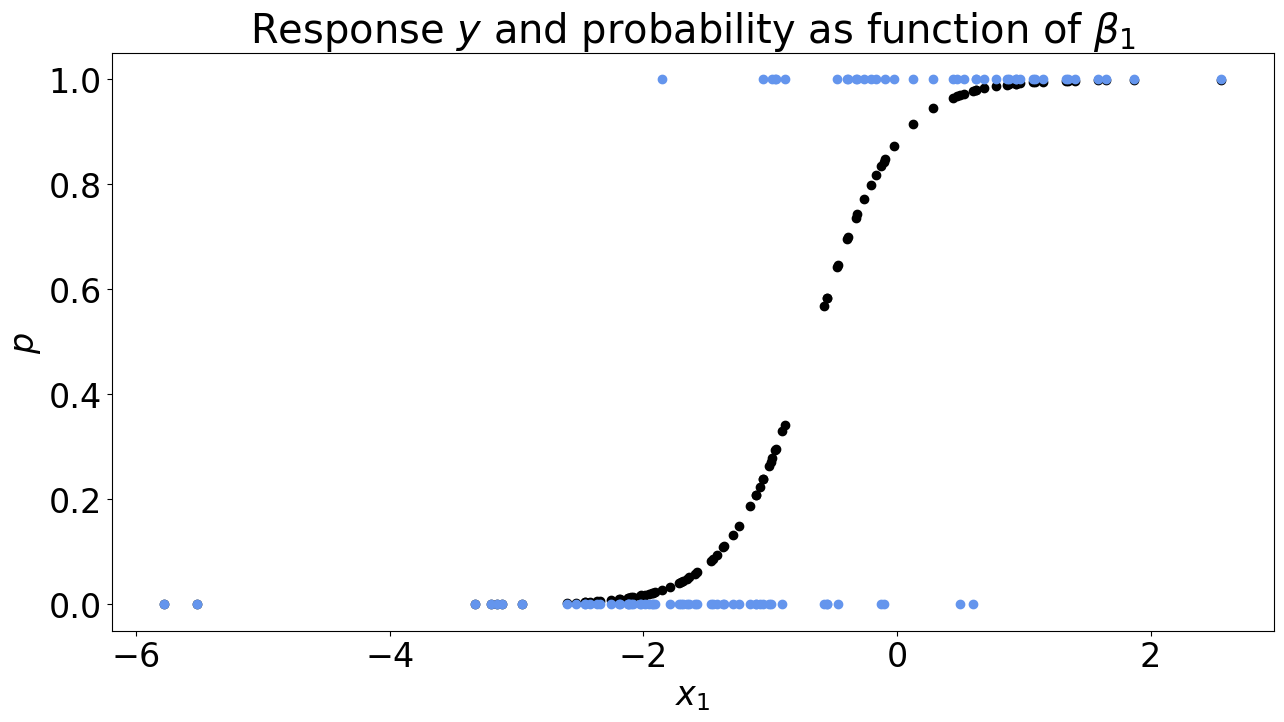

In [3]:
plt.scatter(X[:,1],true_p,c='black')
plt.scatter(X[:,1],Y,c='cornflowerblue')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$p$')
plt.title(r'Response $y$ and probability as function of $\beta_1$')

### Unnormalized posterior plot

In [49]:
# gaussian log density
def gauss_lp(x,mu,logsigma):
    sigma=np.exp(logsigma)
    return -0.5*((x-mu)/sigma)**2-0.5*logsigma-0.5*np.log(2*np.pi)

In [50]:
############################
############################
## posterior distribution ##
############################
############################
#altY=np.maximum(1e-5,np.minimum(1-1e-5,Y))[:,np.newaxis] # to be able to take logarithms
prbs = lambda beta : 1./(1.+np.exp(-true_beta[0]-beta[:,np.newaxis]*X[:,1]))
ll = lambda beta : np.sum(Y*np.log(prbs(beta))+(1-Y)*np.log(1-prbs(beta)),axis=1)
lprior = lambda beta : gauss_lp(beta,0.,np.log(30.))
logp = lambda beta : ll(beta)+lprior(beta) # target p(x,z)

Text(0, 0.5, 'Unnormalized density')

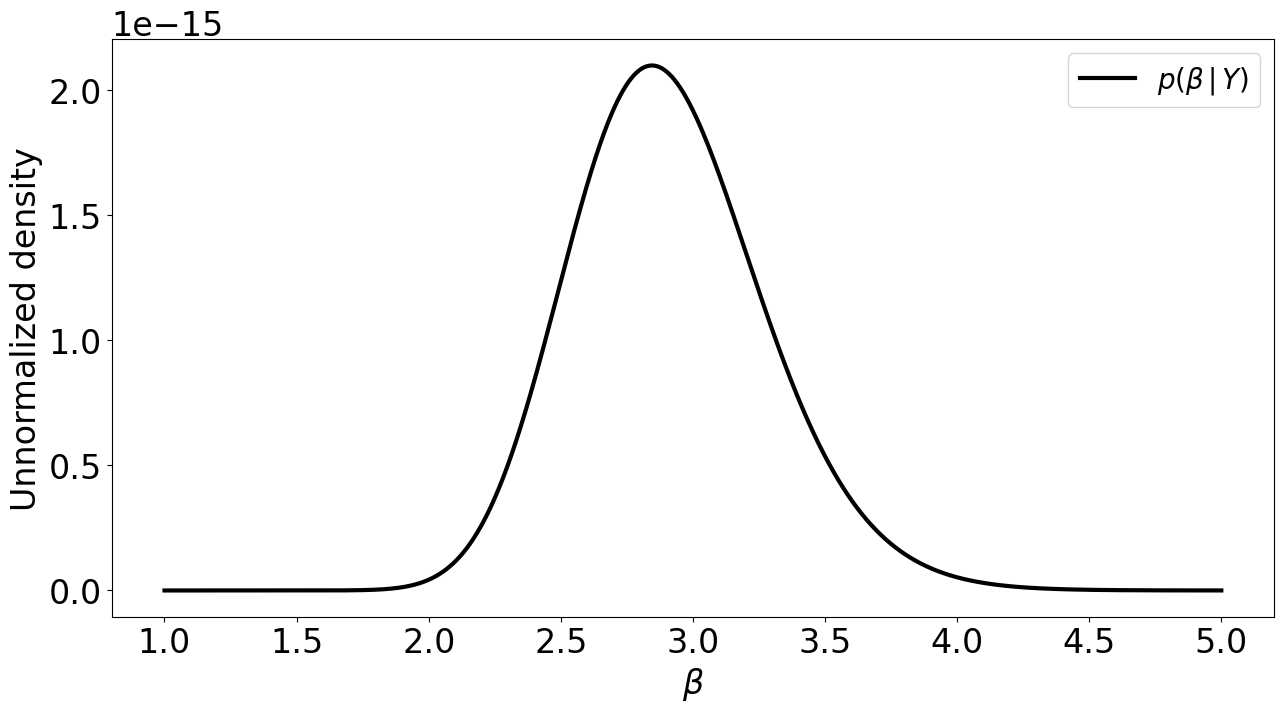

In [51]:
ls=np.linspace(1,5,10000)
target=np.exp(logp(ls))
#target=target/np.sum(target)
plt.plot(ls,target,color='black',lw=3,label=r'$p(\beta\,|\,Y)$')
plt.legend(fontsize='small')
plt.xlabel(r'$\beta$')
plt.ylabel('Unnormalized density')

## Fit model with Stan

In [4]:
# model definition
stan_code = """
data {
  int<lower=0> n; // number of observations
  int y[n]; // responses
  vector[n] x1; // predictors
  real beta0; // intercept
}
parameters {
  real beta1;
}
model {
  beta1 ~ normal(0, 30);
  y ~ bernoulli_logit(beta0+beta1*x1);
}
"""

In [5]:
model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_885816be3a6e229f8e2d0b5893720007 NOW.
In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:836:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948:
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/k3/24

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:344:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr.hpp:46:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr/functor/integrate_ode_rk45.hpp:17:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/numeric/odeint.hpp:37

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:473:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:473:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

164 warnings generated.
In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:836:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948:
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_8858

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:344:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr.hpp:46:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr/functor/integrate_ode_rk45.hpp:17:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/numeric/odeint.hpp:37

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:473:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:846:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::random::linear_congruential_engine<unsigned long lon

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_k5wzksq8/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_917285992258007679.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankdi

163 warnings generated.
ld: warning: directory not found for option '-L/usr/local/opt/ruby/lib'
ld: warning: directory not found for option '-L/usr/local/opt/ruby/lib'


In [6]:
# run in stan
stan_data = {'n': N,
             'y': Y,
             'x1': X[:,1],
             'beta0': true_beta[0]}
fit = model.sampling(data=stan_data, iter=10000, chains=1)


Gradient evaluation took 3.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.078506 seconds (Warm-up)
               0.085184 seconds (Sampling)
               0.16369 seconds (Total)



In [7]:
# summary statistics
print(fit.stansummary(pars=['beta1']))
samples = fit.extract()

Inference for Stan model: anon_model_885816be3a6e229f8e2d0b5893720007.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1   2.92  8.3e-3   0.36   2.26   2.67    2.9   3.14   3.69   1920    1.0

Samples were drawn using NUTS at Wed Apr 19 16:40:36 2023.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


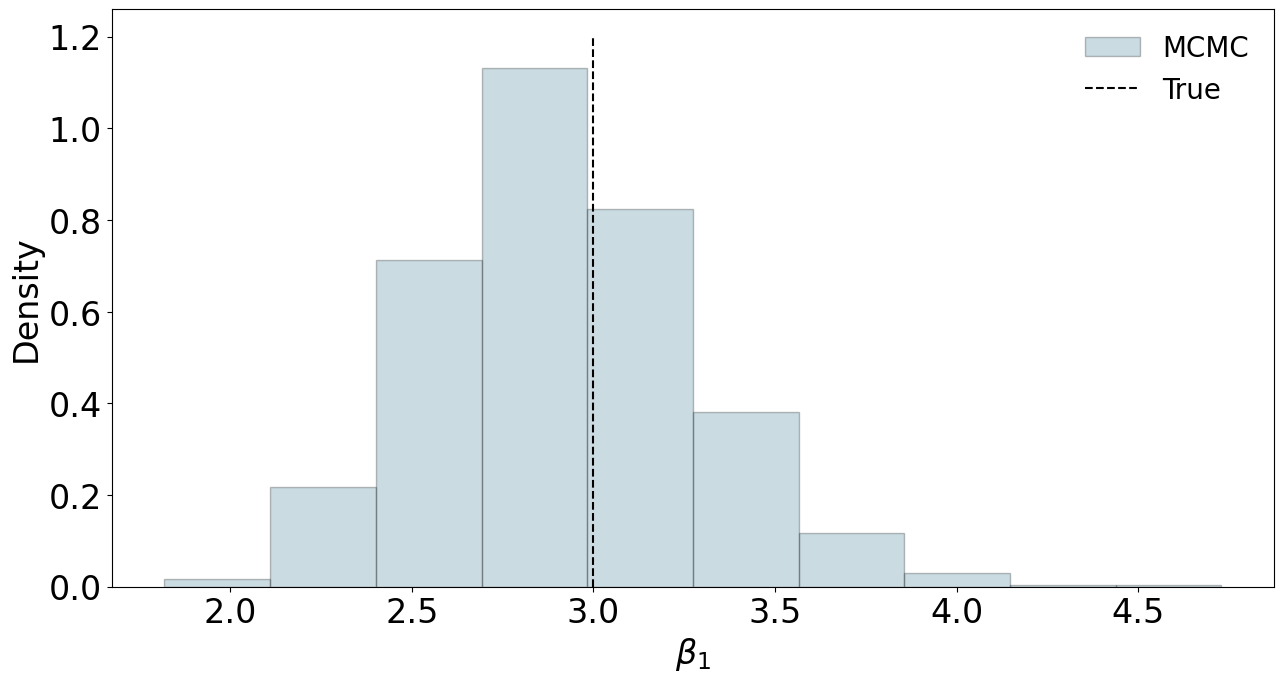

In [8]:
plt.hist(samples['beta1'], color='#2D718EFF',ec='black',alpha=0.25,label='MCMC',density=True)
plt.vlines(true_beta[1],0,1.2,color='black',ls='dashed',label='True')
plt.xlabel(r'$\beta_1$')
plt.ylabel('Density')
leg = plt.legend(fontsize='small',frameon=False)
#for lh in leg.legendHandles: lh.set_alpha(1)
#plt.savefig(fig_path+'logreg_mcmc_scatter.pdf', dpi=300, bbox_inches='tight')

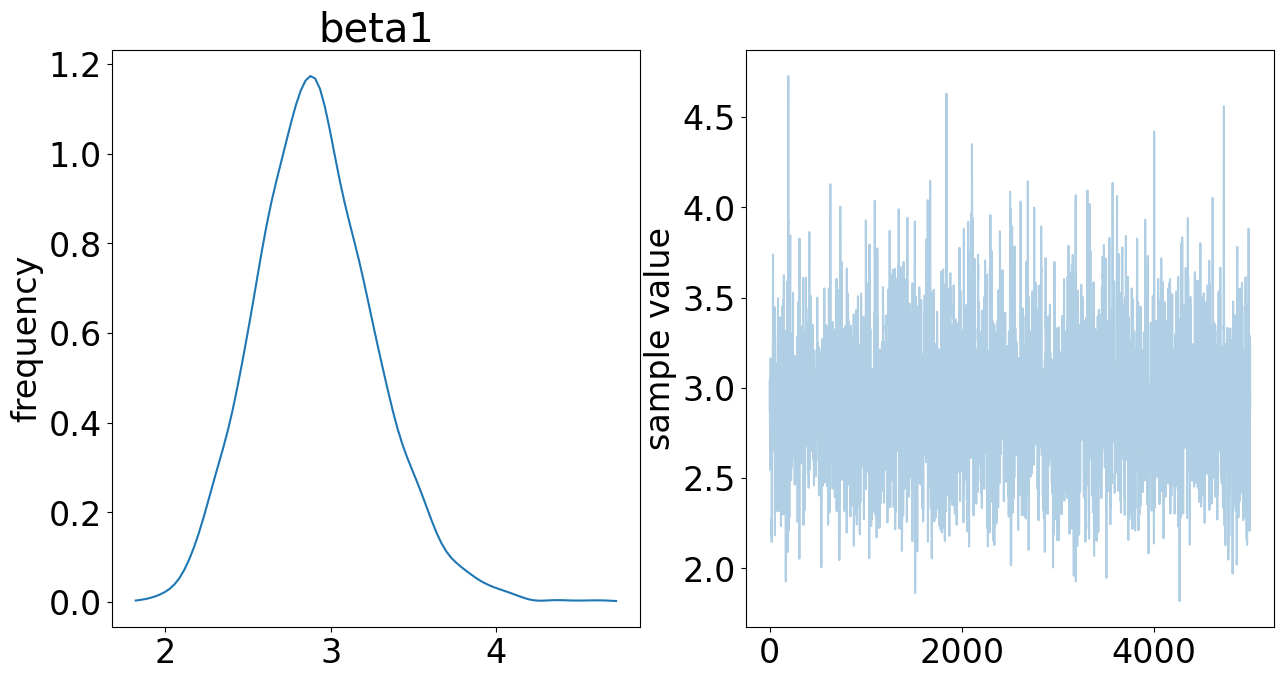

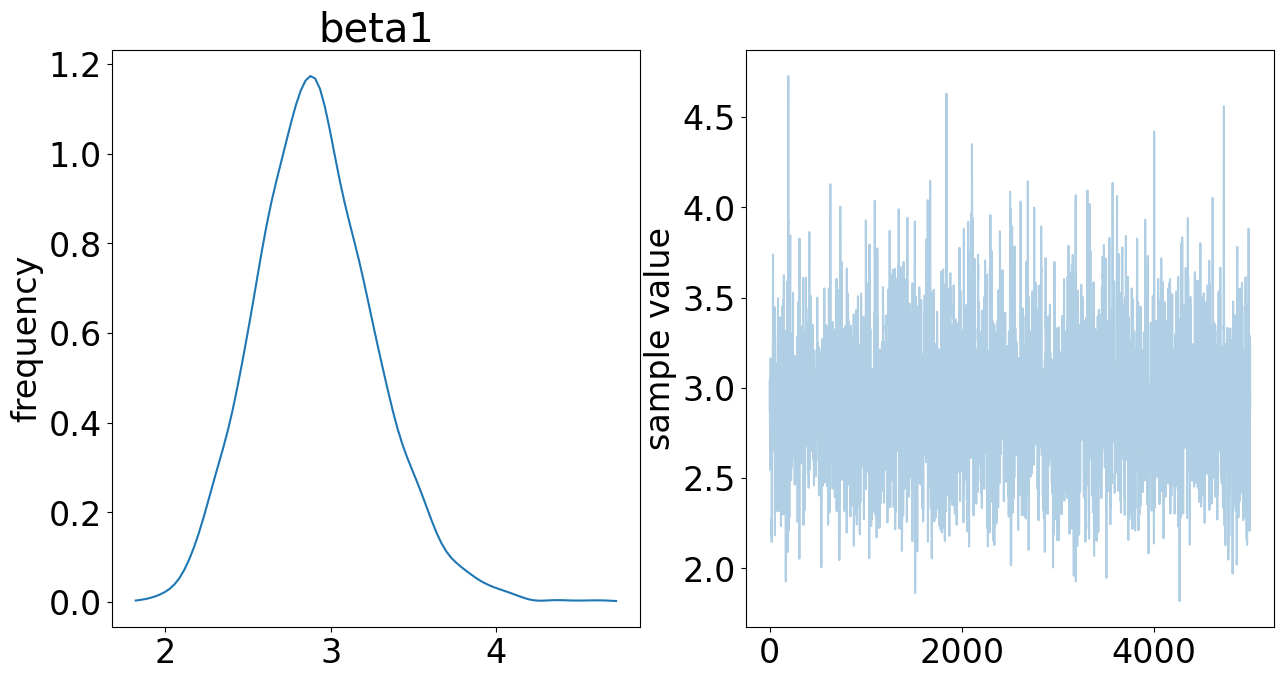

In [9]:
fit.plot()

## Fit variational approximations